In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from astropy.convolution import Gaussian2DKernel, convolve
import cv2
from glob import glob
import os

import ar_analysis as ara
import processing as par

## Path and experiment

In [3]:
base_path = '/archive/Ming.Zhao/awg/2022.03/'
year = 2017

## Load model data for one year

In [26]:
model_data = par.load_model_data(
    base_path, year, 
    exp_name='c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020', 
    variables=['prw', 'pr', 'ivtx', 'ivty'], ar_analysis=True)
model_data['pr'] = model_data.pr * 86400
model_ar_data = par.load_ar_data(base_path, 'c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020', year)
model_ar_data = par.lon_360_to_180(model_ar_data)
model_ar_data = model_ar_data.assign_coords({'lat': model_data.lat, 'lon': model_data.lon})
model_data['ar_shape'] = par.daily_ar_shape(model_ar_data, model_data.time)
model_data['ar_pr'] = par.ar_rain_rate(model_data)
kernel = Gaussian2DKernel(20)
model_data['ss_pr_mean'] = (('lat', 'lon'), convolve(model_data.pr.mean('time'), kernel, boundary='wrap'))
model_data['or_pr_mean'] = model_data.pr.mean('time') - model_data.ss_pr_mean
model_data['ss_ar_pr_mean'] = (('lat', 'lon'), convolve(model_data.ar_pr.mean('time'), kernel, boundary='wrap'))
model_data['or_ar_pr_mean'] = model_data.ar_pr.mean('time') - model_data.ss_ar_pr_mean
model_data = par.sel_na_westcoast(model_data)

/home/Marc.Prange/work/AR-analysis/ar_analysis.py:58: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data['time'] = np.array(data.time.values, dtype='datetime64[1D]')
/home/Marc.Prange/work/AR-analysis/ar_analysis.py:58: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor;

## Load 1 year of warming simulation

In [27]:
model2k_data = par.load_model_data(
    base_path, year, 
    exp_name='c192L33_am4p0_amip_HIRESMIP_nudge_wind_1day_p2K',
    variables=['prw', 'pr', 'ivtx', 'ivty'], ar_analysis=True)
model2k_data['pr'] = model2k_data.pr * 86400
model2k_ar_data = par.load_ar_data(base_path, 'c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020', year)
model2k_ar_data = par.lon_360_to_180(model2k_ar_data)
model2k_ar_data = model_ar_data.assign_coords({'lat': model2k_data.lat, 'lon': model2k_data.lon})
model2k_data['ar_shape'] = par.daily_ar_shape(model2k_ar_data, model2k_data.time)
model2k_data['ar_pr'] = par.ar_rain_rate(model2k_data)
kernel = Gaussian2DKernel(20)
model2k_data['ss_pr_mean'] = (('lat', 'lon'), convolve(model2k_data.pr.mean('time'), kernel, boundary='wrap'))
model2k_data['or_pr_mean'] = model2k_data.pr.mean('time') - model2k_data.ss_pr_mean
model2k_data['ss_ar_pr_mean'] = (('lat', 'lon'), convolve(model2k_data.ar_pr.mean('time'), kernel, boundary='wrap'))
model2k_data['or_ar_pr_mean'] = model2k_data.ar_pr.mean('time') - model2k_data.ss_ar_pr_mean
model2k_data = par.sel_na_westcoast(model2k_data)

/home/Marc.Prange/work/AR-analysis/ar_analysis.py:58: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data['time'] = np.array(data.time.values, dtype='datetime64[1D]')
/home/Marc.Prange/work/AR-analysis/ar_analysis.py:58: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor;

## Load obs data for one year

In [29]:
era5_data = par.load_era5_data(base_path, year, ['ivtx', 'ivty', 'prw'], ar_analysis=True)
era5_ar_data = par.load_ar_data(base_path, 'c192_obs', year)
era5_ar_data = par.lon_360_to_180(era5_ar_data)
obs_pr_data = par.load_pr_obs_data(base_path, 'c192_obs', year)
obs_pr_data = par.lon_360_to_180(obs_pr_data)
era5_data = xr.merge([era5_data, obs_pr_data]).rename({'precipitation': 'pr'})
era5_data['ar_shape'] = par.daily_ar_shape(era5_ar_data, era5_data.time)
era5_data['ar_pr'] = par.ar_rain_rate(era5_data)
kernel = Gaussian2DKernel(20)
era5_data['ss_pr_mean'] = (('lat', 'lon'), convolve(era5_data.pr.mean('time'), kernel, boundary='wrap'))
era5_data['or_pr_mean'] = era5_data.pr.mean('time') - era5_data.ss_pr_mean
era5_data['ss_ar_pr_mean'] = (('lat', 'lon'), convolve(era5_data.ar_pr.mean('time'), kernel, boundary='wrap'))
era5_data['or_ar_pr_mean'] = era5_data.ar_pr.mean('time') - era5_data.ss_ar_pr_mean
era5_data = par.sel_na_westcoast(era5_data)

/home/Marc.Prange/work/AR-analysis/ar_analysis.py:78: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data['time'] = np.array(data.time.values, dtype='datetime64[1D]')
/home/Marc.Prange/work/AR-analysis/ar_analysis.py:78: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor;

In [62]:
model_data.pr.isel(time=0)

<xarray.DataArray 'pr' (lat: 360, lon: 576)>
dask.array<getitem, shape=(360, 576), dtype=float64, chunksize=(360, 576), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2005-07-02T12:00:00
  * lon      (lon) float64 -179.7 -179.1 -178.4 -177.8 ... 178.4 179.1 179.7
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
    p500     float64 ...

## Load clim. mean data

In [63]:
era5_data = xr.open_dataset('/archive/Marc.Prange/clim_means/c192_obs/c192_obs_2010-2020_mean.precipitation.nc').rename({'precipitation': 'pr'}).squeeze()
era5_data = par.lon_360_to_180(era5_data)
kernel = Gaussian2DKernel(20)
era5_data['ss_pr_mean'] = (('lat', 'lon'), convolve(era5_data.pr, kernel, boundary='wrap'))
era5_data['or_pr_mean'] = era5_data.pr - era5_data.ss_pr_mean
# era5_data = par.sel_na_westcoast(era5_data)

model_data = xr.open_mfdataset(
    '/archive/Marc.Prange/clim_means/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020/'
    'c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_2020_1990-2020_mean.*.nc').isel(time=0).squeeze()
model_data['pr'] = model_data.pr * 86400
model_data['prsn'] = model_data.pr * 86400
model_data['evap_land'] = model_data.evap_land * 86400
model_data = par.lon_360_to_180(model_data)
model_data['ss_pr_mean'] = (('lat', 'lon'), convolve(model_data.pr, kernel, boundary='wrap'))
model_data['or_pr_mean'] = model_data.pr - model_data.ss_pr_mean
# model_data = par.sel_na_westcoast(model_data)

model2k_data = xr.open_mfdataset(
    '/archive/Marc.Prange/clim_means/c192L33_am4p0_amip_HIRESMIP_nudge_wind_1day_p2K/'
    'c192L33_am4p0_amip_HIRESMIP_nudge_wind_1day_p2K_1990-2020_mean.*.nc').squeeze()
model2k_data['prsn'] = model2k_data.pr * 86400
model2k_data['evap_land'] = model2k_data.evap_land * 86400
model2k_data['pr'] = model2k_data.pr * 86400
model2k_data = par.lon_360_to_180(model2k_data)
model2k_data['ss_pr_mean'] = (('lat', 'lon'), convolve(model2k_data.pr, kernel, boundary='wrap'))
model2k_data['or_pr_mean'] = model2k_data.pr - model2k_data.ss_pr_mean
# model2k_data = par.sel_na_westcoast(model2k_data)

era5_ar_data = par.load_ar_data(base_path, 'c192_obs', year)
era5_ar_data = par.lon_360_to_180(era5_ar_data)

Exception: array and kernel have differing number of dimensions.

In [6]:
model_data

<xarray.Dataset>
Dimensions:     (bnds: 2, lon: 576, lat: 360)
Coordinates:
    time        datetime64[ns] 2005-07-02T12:00:00
  * lon         (lon) float64 -179.7 -179.1 -178.4 -177.8 ... 178.4 179.1 179.7
  * lat         (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (bnds) datetime64[ns] dask.array<chunksize=(2,), meta=np.ndarray>
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(576, 2), meta=np.ndarray>
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    average_DT  timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>
    evap_land   (lat, lon) float64 dask.array<chunksize=(360, 576), meta=np.ndarray>
    pr          (lat, lon) float64 dask.array<chunksize=(360, 576), meta=np.ndarray>
    prsn        (lat, lon) float64 dask.array<chunksize=(360, 576), meta=np.ndarray>
    prw         (lat, lon) float32 dask.array<chunksize=(360, 576), meta=np.ndarray>
    ts          (lat, lon) float32 dask.array<chunksize=(360, 576), meta=np.ndarray>
    ss_pr_mean  (lat, lon) float64 0.5333 0.5348 0.5362 ... 0.5298 0.5313 0.5328
    or_pr_mean  (lat, lon) float64 dask.array<chunksize=(360, 576), meta=np.ndarray>
Attributes: (12/13)
    CDI:                   Climate Data Interface version 2.1.1 (https://mpim...
    Conventions:           CF-1.6
    title:                 c192L33_am4p0_amip_HIRESMIP_nudge_wind_1951_1979
    associated_files:      lake_area: 19900101.land_static.nc soil_area: 1990...
    grid_type:             regular
    grid_tile:             N/A
    ...                    ...
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Fri Dec  2 12:50:35 2022
    hostname:              pp037
    history:               Thu Mar 14 10:24:03 2024: cdo -timmean /vftmp/Marc...
    external_variables:    land_area
    CDO:                   Climate Data Operators version 2.1.1 (https://mpim...

## Precip / AR precip fraction and biases

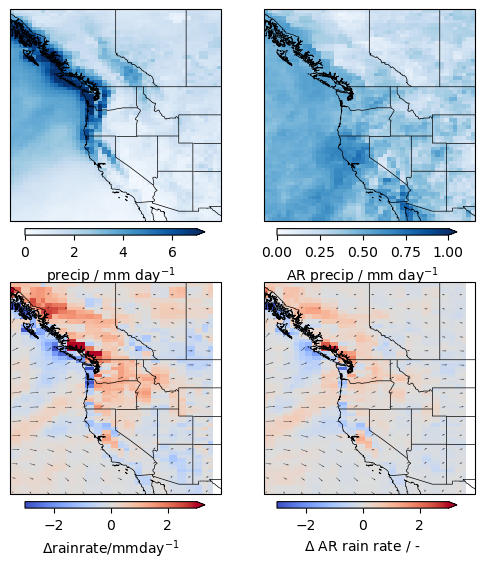

In [40]:

cb_props = {
        'x': 0.15, 
        'y': 0.1,
        'w': 0.3,
        'h': 0.01,
        'label': r'$\Delta \mathrm{rain rate} / \mathrm{mm day}^{-1}$',
        'vmin': -3,
        'vmax': 3,
    }
fig = plt.figure(figsize=(6, 6.5))
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
c = ax1.pcolormesh(
    era5_data.lon, era5_data.lat, 
    era5_data.pr.mean('time'), 
    vmin=0, vmax=7, cmap='Blues')
cax = fig.add_axes([0.15, 0.52, 0.3, 0.01])
cb1 = fig.colorbar(
    c, cax=cax, spacing='proportional', orientation='horizontal',
    extend='max', label='precip / mm day$^{-1}$')
ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
c = ax2.pcolormesh(
    era5_data.lon, era5_data.lat, 
    era5_data.ar_pr.mean('time') / era5_data.pr.mean('time'), 
    vmin=0, vmax=1, cmap='Blues')
cax = fig.add_axes([0.57, 0.52, 0.3, 0.01])
cb1 = fig.colorbar(
    c, cax=cax, spacing='proportional', orientation='horizontal',
    extend='max', label='AR precip / mm day$^{-1}$')

ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
fig, ax3 = ara.plot_bias_map(
    fig, ax3, model_data.mean('time'), era5_data.mean('time'), 
    era5_data.mean('time'), var='pr', cb_props=cb_props, rel_error=False, mask_ar=False)
cb_props = {
        'x': 0.57, 
        'y': 0.1,
        'w': 0.3,
        'h': 0.01,
        'label': r'$\Delta$ AR rain rate / -',
        'vmin': -3,
        'vmax': 3,
    }
ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())
fig, ax4 = ara.plot_bias_map(
    fig, ax4, model_data.mean('time'), era5_data.mean('time'), 
    era5_data.mean('time'), var='ar_pr', cb_props=cb_props, rel_error=False, mask_ar=False)
for axis in [ax1, ax2, ax3, ax4]:
    axis.set_extent([-135, -105, 30, 60], crs=ccrs.PlateCarree())
    axis.coastlines("10m", linewidth=0.5)
    # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
    # axis.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=0.5)
    axis.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    axis.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
# ax1.set(title='MSWEP precip')
# ax2.set(title='MSWEP AR precip fraction')
# ax3.set(title='model precip bias')
# ax3.set(title='model AR precip bias')

## Distinguish synoptic scale (SS) and orographic (OR) precip

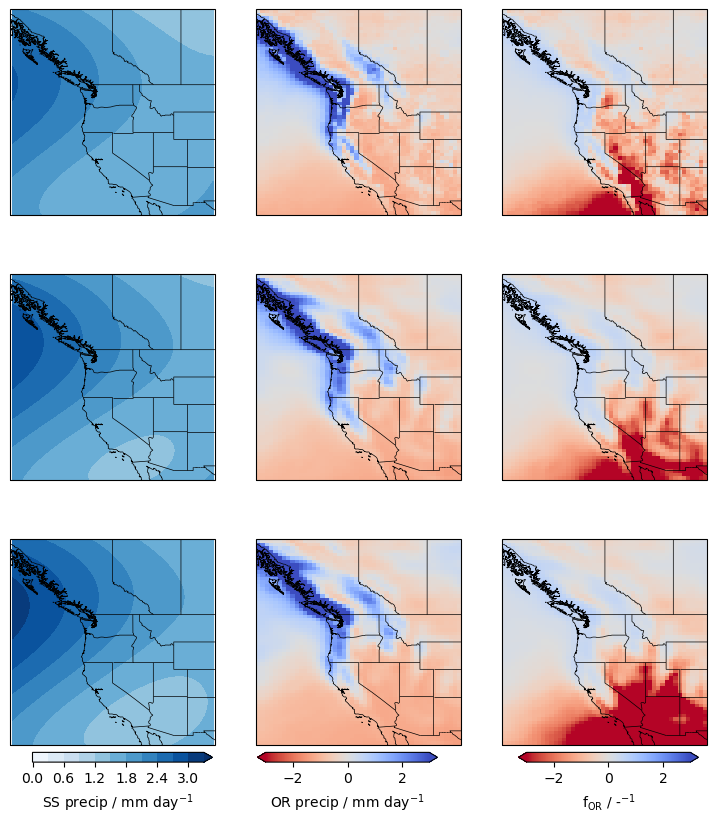

In [13]:
pr_str = 'pr'
fig = plt.figure(figsize=(9, 9.75))
ax1 = fig.add_subplot(331, projection=ccrs.PlateCarree())
c = ax1.contourf(
    era5_data.lon, era5_data.lat, 
    era5_data[f'ss_{pr_str}_mean'], 
    levels=np.arange(0, 3.6, 0.3), cmap='Blues')
ax2 = fig.add_subplot(332, projection=ccrs.PlateCarree())
c = ax2.pcolormesh(
    era5_data.lon, era5_data.lat, 
    era5_data[f'or_{pr_str}_mean'],
    vmin=-3, vmax=3, cmap='coolwarm_r')
ax3 = fig.add_subplot(333, projection=ccrs.PlateCarree())
c = ax3.pcolormesh(
    era5_data.lon, era5_data.lat, 
    era5_data[f'or_{pr_str}_mean'] / era5_data[f'{pr_str}'],
    vmin=-3, vmax=3, cmap='coolwarm_r')
ax4 = fig.add_subplot(334, projection=ccrs.PlateCarree())
c = ax4.contourf(
    model_data.lon, model_data.lat, 
    model_data[f'ss_{pr_str}_mean'], 
    levels=np.arange(0, 3.6, 0.3), cmap='Blues')
ax5 = fig.add_subplot(335, projection=ccrs.PlateCarree())
c = ax5.pcolormesh(
    model_data.lon, model_data.lat, 
    model_data[f'or_{pr_str}_mean'], 
    vmin=-3, vmax=3, cmap='coolwarm_r')
ax6 = fig.add_subplot(336, projection=ccrs.PlateCarree())
c = ax6.pcolormesh(
    model_data.lon, model_data.lat, 
    model_data[f'or_{pr_str}_mean'] / model_data[f'{pr_str}'],
    vmin=-3, vmax=3, cmap='coolwarm_r')
ax7 = fig.add_subplot(337, projection=ccrs.PlateCarree())
c = ax7.contourf(
    model2k_data.lon, model2k_data.lat, 
    model2k_data[f'ss_{pr_str}_mean'], 
    levels=np.arange(0, 3.6, 0.3), cmap='Blues', extend='max')
cax = fig.add_axes([0.15, 0.1, 0.2, 0.01])
cb1 = fig.colorbar(
    c, cax=cax, spacing='proportional', orientation='horizontal',
    label='SS precip / mm day$^{-1}$', extend='max')
ax8 = fig.add_subplot(338, projection=ccrs.PlateCarree())
c = ax8.pcolormesh(
    model2k_data.lon, model2k_data.lat, 
    model2k_data[f'or_{pr_str}_mean'], 
    vmin=-3, vmax=3, cmap='coolwarm_r')
cax = fig.add_axes([0.4, 0.1, 0.2, 0.01])
cb1 = fig.colorbar(
    c, cax=cax, spacing='proportional', orientation='horizontal',
    label='OR precip / mm day$^{-1}$', extend='both')
ax9 = fig.add_subplot(339, projection=ccrs.PlateCarree())
c = ax9.pcolormesh(
    model2k_data.lon, model2k_data.lat, 
    model2k_data[f'or_{pr_str}_mean'] / model2k_data[f'{pr_str}'],
    vmin=-3, vmax=3, cmap='coolwarm_r')
cax = fig.add_axes([0.69, 0.1, 0.2, 0.01])
cb1 = fig.colorbar(
    c, cax=cax, spacing='proportional', orientation='horizontal',
    label='f$_\mathrm{OR}$ / -$^{-1}$', extend='both')

for axis in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]:
    axis.set_extent([-135, -105, 30, 60], crs=ccrs.PlateCarree())
    axis.coastlines("10m", linewidth=0.5)
    # axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
    # axis.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=0.5)
    axis.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    axis.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
plt.savefig('plots/western_na_or_ss_rr_model_model2k_mswep_maps.png', dpi=300)

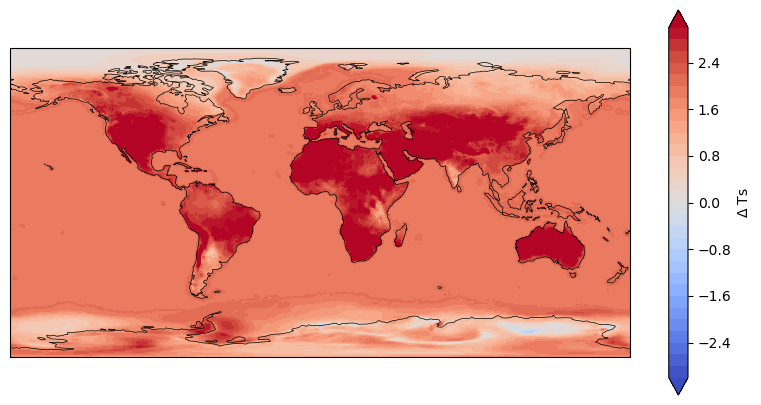

In [31]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection=ccrs.PlateCarree())
c = ax.contourf(
    model_data.lon, model_data.lat, 
    (model2k_data.ts - model_data.ts), 
    levels=np.arange(-3, 3.2, 0.2), cmap='coolwarm', extend='both')
plt.colorbar(c, label='$\Delta$ Ts')
ax.coastlines("110m", linewidth=0.5)

/home/Marc.Prange/miniconda3/envs/AR_analysis/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/Marc.Prange/miniconda3/envs/AR_analysis/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'negative_linestyle'
  result = super().contour(*args, **kwargs)


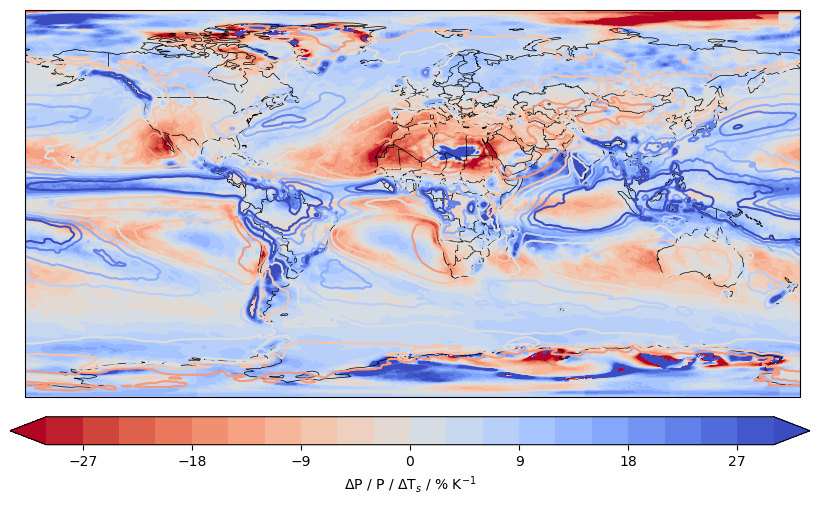

In [33]:
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
c = ax1.contourf(
    model_data.lon, model_data.lat, 
    (model2k_data['pr'] - model_data['pr']) / model_data['pr']/ (model2k_data.ts - model_data.ts)*100, 
    levels=np.arange(-30, 33, 3), cmap='coolwarm_r', extend='both')
c1 = ax1.contour(model_data.lon, model_data.lat,
                 model_data['pr'] - model_data.pr.mean(),
                 levels=np.arange(-4, 5, 1),
                 cmap='coolwarm_r', negative_linestyle='dashed')
cax = fig.add_axes([0.11, 0.15, 0.8, 0.04])
cb1 = fig.colorbar(
    c, cax=cax, spacing='proportional', orientation='horizontal',
    label=r'$\Delta$P / P / $\Delta$T$_{s}$ / % K$^{-1}$', extend='both')
# ax1.set_extent([-135, -105, 30, 60], crs=ccrs.PlateCarree())
ax1.coastlines("110m", linewidth=0.5)
# axis.add_feature(cfeature.LAKES.with_scale('10m'), facecolor='tab:blue', edgecolor='tab:blue', linewidth=0.5)
# axis.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='tab:blue', linewidth=0.5)
ax1.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
# ax1.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
plt.savefig('plots/pr_rel_change_pr_anomaly_model2k-model_ctrl.png', dpi=300)

/home/Marc.Prange/miniconda3/envs/AR_analysis/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


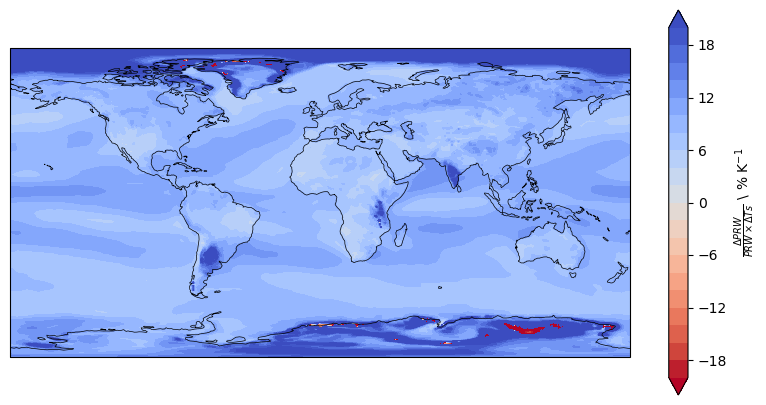

In [50]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
c = ax1.contourf(
    model_data.lon, model_data.lat, 
    (model2k_data['prw'] - model_data['prw']) / model_data['prw']/ (model2k_data.ts - model_data.ts)*100, 
    levels=np.arange(-20, 22, 2), cmap='coolwarm_r', extend='both')
plt.colorbar(c, label=r'$\frac{\Delta PRW}{PRW\times\Delta Ts}$ \ % K$^{-1}$')
ax1.coastlines("110m", linewidth=0.5)

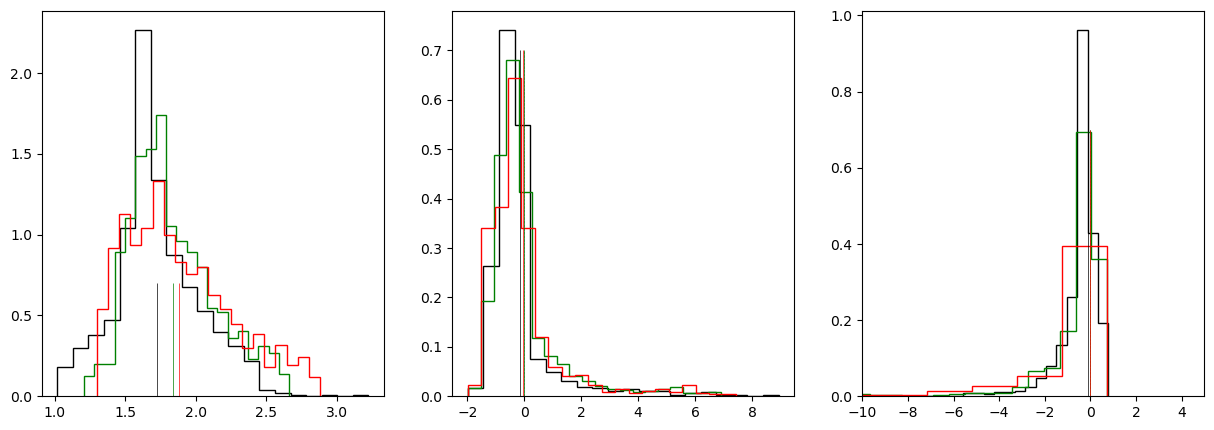

In [26]:
era5_ar_data = par.sel_na_westcoast(era5_ar_data)
land = ~np.isnan(era5_ar_data.islnd)

nbins = 20
pr_str = 'pr'
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].hist(
    era5_data[f'ss_{pr_str}_mean'].where(land).values.flatten(),
    bins=nbins,
    histtype='step',
    density=True, 
    color='black')
axs[0].hist(
    model_data[f'ss_{pr_str}_mean'].where(land).values.flatten(),
    bins=nbins,
    histtype='step',
    density=True, 
    color='green')
axs[0].hist(
    model2k_data[f'ss_{pr_str}_mean'].where(land).values.flatten(),
    bins=nbins,
    histtype='step',
    density=True, 
    color='red')
axs[0].vlines(
    [era5_data[f'ss_{pr_str}_mean'].where(land).mean(), 
     model_data[f'ss_{pr_str}_mean'].where(land).mean(), 
     model2k_data[f'ss_{pr_str}_mean'].where(land).mean()],
    [0, 0, 0],
    [0.7, 0.7, 0.7],
    colors=['black', 'green', 'red'], lw=0.5,)

axs[1].vlines(0, 0, 0.7, color='gray', ls='--', lw=0.5)
axs[1].hist(
    era5_data[f'or_{pr_str}_mean'].where(land).values.flatten(),
    bins=nbins,
    histtype='step',
    density=True, 
    color='black')
axs[1].hist(
    model_data[f'or_{pr_str}_mean'].where(land).values.flatten(),
    bins=nbins,
    histtype='step',
    density=True, 
    color='green')
axs[1].hist(
    model2k_data[f'or_{pr_str}_mean'].where(land).values.flatten(),
    bins=nbins,
    histtype='step',
    density=True, 
    color='red')
axs[1].vlines(
    [era5_data[f'or_{pr_str}_mean'].where(land).mean(), 
     model_data[f'or_{pr_str}_mean'].where(land).mean(), 
     model2k_data[f'or_{pr_str}_mean'].where(land).mean()],
    [0, 0, 0],
    [0.7, 0.7, 0.7],
    colors=['black', 'green', 'red'], lw=0.5,)

axs[2].vlines(0, 0, 0.7, color='gray', ls='--', lw=0.5)
axs[2].hist(
    era5_data[f'or_{pr_str}_mean'].where(land).values.flatten() / era5_data[f'{pr_str}'].where(land).values.flatten(),
    bins=nbins,
    histtype='step',
    density=True, 
    color='black')
axs[2].hist(
    model_data[f'or_{pr_str}_mean'].where(land).values.flatten() / model_data[f'{pr_str}'].where(land).values.flatten(),
    bins=nbins,
    histtype='step',
    density=True, 
    color='green')
axs[2].hist(
    model2k_data[f'or_{pr_str}_mean'].where(land).values.flatten() / model2k_data[f'{pr_str}'].where(land).values.flatten(),
    bins=nbins,
    histtype='step',
    density=True, 
    color='red')
axs[2].vlines(
    [era5_data[f'or_{pr_str}_mean'].where(land).mean() / era5_data[f'{pr_str}'].where(land).mean(), 
     model_data[f'or_{pr_str}_mean'].where(land).mean() / model_data[f'{pr_str}'].where(land).mean(), 
     model2k_data[f'or_{pr_str}_mean'].where(land).mean() / model2k_data[f'{pr_str}'].where(land).mean()],
    [0, 0, 0],
    [0.7, 0.7, 0.7],
    colors=['black', 'green', 'red'], lw=0.5,)
axs[2].set(xlim=[-10, 5])
plt.savefig('plots/western_na_land_or_ss_rr_model_model2k_mswep_hist.png', dpi=300)
# axs[1].set(xlim=[-5, 5])